In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3
import ray.rllib.agents.ars as ars
import xarray as xr

from run_rllib import PPOCTrainer, PPOFracTrainer, A2CCTrainer, A2CFracTrainer, ARSCTrainer, ARSFracTrainer
string_2_trainer = {"PPOC":PPOCTrainer, "PPOFrac":PPOFracTrainer, "A2CC":A2CCTrainer, \
                    "A2CFrac":A2CFracTrainer, "ARSC":ARSCTrainer, "ARSFrac":ARSFracTrainer}

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle5 as pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
import matplotlib
%matplotlib inline

import pandas as pd
from multiprocessing import Pool
from itertools import product
from seagul.plot import smooth_bounded_curve
import os
import time
import re
from seagul.mesh import mesh_dim

import time
import torch
import copy
#jup_dir = "/home/sgillen/work/"
#jup_dir = "/home/sgillen/"

ray.shutdown()
ray.init()

def do_rollout_pert(env, trainer, initial_pos, num_steps=10, deterministic=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []

    obs = my_reset(env, initial_pos)
    done = False

    for cur_step in range(num_steps):
        obs_list.append(obs)

        samples, _, out_dict = trainer.compute_action(obs, full_fetch=True)
        means = out_dict['action_dist_inputs']
        means = means[:len(means)//2]

        if deterministic:
            act = means
        else:
            act = samples
        obs, rew, done, _ = env.step(act)
        
        act_list.append(act)
        rew_list.append(rew)

    
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew



# Do a rollout and track contact, will only work with Mujoco
def do_contact_rollout(env, trainer, ep_length, render=False, deterministic=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []
    con_list = []

    obs = env.reset()
    cur_step = 0

    while cur_step < ep_length:
        obs_list.append(obs)
        con_list.append(env.unwrapped.sim.data.ncon)

        
        samples, _, out_dict = trainer.compute_action(obs, full_fetch=True)
        means = out_dict['action_dist_inputs']
        means = means[:len(means)//2]

        if deterministic:
            act = means
        else:
            act = samples
        
        obs, rew, done, _ = env.step(act)

        if render:
            env.render()
            time.sleep(.01)
        
        act_list.append(act)
        rew_list.append(rew)

        cur_step += 1

    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    
    ep_con = np.array(con_list)
    ep_con = ep_con.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_con


def mdim_stable(obs, act, rew):
    m = None

    if obs.shape[0] == 1000:
        gait_start = 200
        target_obs = obs[gait_start:]
    else:
        m = obs.shape[1] / 2

    if m is None:
        m, _, _, _ = mesh_dim(target_obs)
        m = np.clip(m, .1, obs.shape[1] / 2)

    return m

base_dir = os.getcwd() + "/simple_fr0/"

trainer_dict = {}

        
def get_config_and_df(checkpoint_path, plt_reward=False):
    config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
    config = pickle.load(open(config_path, 'rb'))
    env_name = config['env']


    csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
    df = pd.read_csv(csv_path)
    if plt_reward:
        plt.plot(df['episode_reward_mean'])
        plt.figure()
        
    return config, df
    
    

for trainer_dir in os.scandir(base_dir):
    trainer_name = trainer_dir.path.split("/")[-1].split("_")[0]
    print("trainer_name: ", trainer_name)
    for run_dir in os.scandir(trainer_dir.path):
        env_name = re.search("env=([a-zA-Z1-9\-])+", run_dir.path)
        try:
            env_name = env_name.group(0).split("=")[1]
            for run_file in os.scandir(run_dir.path):
                if "checkpoint_" in run_file.path:
                    checkpoint_path = f"{run_file.path}/checkpoint-{run_file.path.split('_')[-1].lstrip('0')}"
                    #print(checkpoint_path)


                    if trainer_name not in trainer_dict:
                        trainer_dict[trainer_name] = {env_name:[checkpoint_path]}
                    else:
                        if env_name not in trainer_dict[trainer_name]:
                            trainer_dict[trainer_name][env_name] = [checkpoint_path]
                        else:
                            trainer_dict[trainer_name][env_name].append(checkpoint_path)


        except AttributeError:
            print(f"excepting {run_dir.path} from run_dirs")


Instructions for updating:
non-resource variables are not supported in the long term


/home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")
2021-05-14 13:36:00,071	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8266


trainer_name:  PPOFrac
excepting /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/experiment_state-2021-05-06_19-14-11.json from run_dirs
excepting /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/basic-variant-state-2021-05-06_19-14-11.json from run_dirs
trainer_name:  PPOC


In [2]:
trainer_name = "PPOC"
seed = 0
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# rollout_length = 1000

#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,2,3,4,5,6,7,8,9]
# rollout_length = 100
# lookback_length = 5
#===============================
env_name = "Hopper-v2"

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

rollout_length = 1000
# ===============================



env = gym.make(env_name)
n_states = env.observation_space.shape[0]
del env
# data = torch.load(f"./data_mcshdim4/{env_name}.xr")
# policy_dict = data.policy_dict

# init_data = torch.load(f"./data17/{env_name}.xr")
# init_pol_dict = init_data.policy_dict
# policy_dict['identity'] = init_pol_dict['identity']
# policy_dict['madodiv'] = init_pol_dict['madodiv']



# exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
# num_seeds = len(policy_dict[exp_names[0]])
# mesh_sizes_dict = {}

running build_ext


(pid=15884) WARNING:tensorflow:From /home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/tensorflow_core/python/compat/v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=15884) Instructions for updating:
(pid=15884) non-resource variables are not supported in the long term
(pid=15885) WARNING:tensorflow:From /home/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/tensorflow_core/python/compat/v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=15885) Instructions for updating:
(pid=15885) non-resource variables are not supported in the long term
(pid=15884) /home/sgillen/work/seagul/seagul/envs/__init__.py:49: UserWarning: Warning, pybullet envs not installed
(pid=15884)   warnings.warn("Warning, pybullet envs not installed")
(pid=15885) /home/sgillen/work/seagul/seagul/e

(pid=15884) running build_ext
(pid=15885) running build_ext


2021-05-14 14:20:29,768	INFO trainable.py:378 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/better_benchmarks/simple_fr0/PPOFrac_2021-05-06_19-14-11/PPOFrac_Hopper-v2_e98ad_00007_7_env=Hopper-v2_2021-05-06_19-14-11/checkpoint_000304/checkpoint-304
2021-05-14 14:20:29,772	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 304, '_timesteps_total': None, '_time_total': 49048.22232532501, '_episodes_total': 88586}


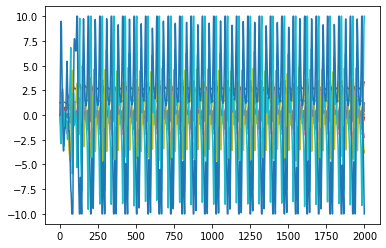

<Figure size 432x288 with 0 Axes>

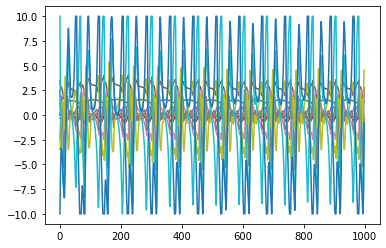

In [11]:
trainer_name = "PPOFrac"
trainer = None

num_seeds = len(trainer_dict[trainer_name][env_name])

checkpoint_path = list(trainer_dict[trainer_name][env_name])[0]

config, df = get_config_and_df(checkpoint_path)


if trainer is None:
    trainer = string_2_trainer[trainer_name](config)

config["reuse_actors"] = True
trainer.reset_config(config)
trainer.restore(checkpoint_path)
env = trainer.env_creator({})


nom_obs, nom_acts, nom_rews, nom_con = do_contact_rollout(env,trainer,rollout_length*2,deterministic=True)

plt.plot(nom_obs); plt.figure()

i_nom_obs = 430
# while nom_con[i_nom_obs] or nom_con[i_nom_obs+1]:# or nom_con[i_nom_obs+2]:
#     i_nom_obs+=1
#     if i_nom_obs >= 998:
#         failed = True
#         break

# if failed:
#     print(f"post {post}, seed {seed}, run {run} failed!")
#     eigs.loc[post][i_seed][run] = float('nan')
#     eigs_bc.loc[post][i_seed][run] = float('nan')
#     failed = False

nominal_state = nom_obs[i_nom_obs]

#obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
#cmp_point = obs[-1]

delta = .05
nominal_state = nom_obs[i_nom_obs]

#obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
#cmp_point = obs[-1]


initial_conditions = []
for i,s in enumerate(nominal_state):
    nominal_state_p = np.copy(nominal_state)
    nominal_state_m = np.copy(nominal_state)
    nominal_state_p[i] += delta
    nominal_state_m[i] -= delta

    initial_conditions.append((np.copy(nominal_state_p), np.copy(nominal_state_m)))
    #initial_conditions.append((nominal_state_p, nominal_state_m))
    

initial_condition = initial_conditions[3]
init_state_p , init_state_m = initial_condition
rollout_obs_p, rollout_acts_p, rollout_rews_p = do_rollout_pert(env,trainer, init_state_p, num_steps=rollout_length,deterministic=True)
rollout_obs_m, rollout_acts_m, rollout_rews_m = do_rollout_pert(env,trainer, init_state_m, num_steps=rollout_length,deterministic=True)

sdiff = (rollout_obs_p-nom_obs[i_nom_obs:i_nom_obs+rollout_length])

diffs = np.linalg.norm(np.abs(rollout_obs_p-nom_obs[i_nom_obs:i_nom_obs+rollout_length]),axis=1)

plt.figure()
plt.plot(rollout_obs_p)
#i_min = np.argmin(np.linalg.norm(diffs, axis=1)) 

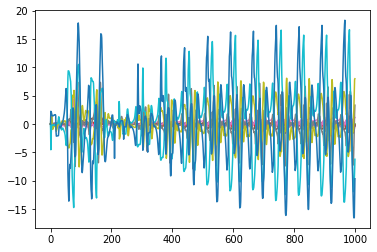

In [12]:
plt.plot(sdiff);

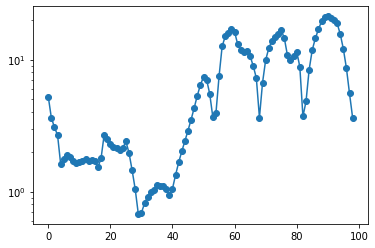

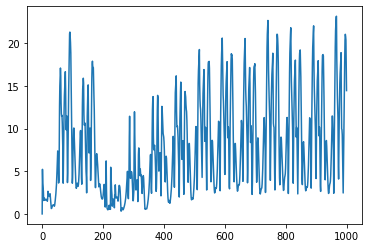

In [28]:
plt.semilogy(diffs[1:100],'-o');
plt.figure();
plt.plot(diffs)

In [ ]:
d1 = 1
d2 = d1+6

last_forward_len = 100
for forward_len in [100,200,300,400,500]:

    plt.plot(nom_obs[i_nom_obs:i_nom_obs+forward_len,d1],nom_obs[i_nom_obs:i_nom_obs+forward_len,d2],marker='o');
    plt.plot(rollout_obs_m[:forward_len,d1], rollout_obs_m[:forward_len,d2], marker='o');
    plt.legend(['Nominal', 'Perturbed'])
    plt.figure();

In [ ]:
num_seeds = len(trainer_dict[trainer_name][env_name])
num_runs = 10
     
eigs = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer":  list(trainer_dict.keys())})

eigs2 = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer":  list(trainer_dict.keys())})

eigs_bc = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer": list(trainer_dict.keys())})


eigs_in = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer":  list(trainer_dict.keys())})

failed = False
for trainer_name in trainer_dict.keys():
    trainer = None
    for i_seed, checkpoint_path in enumerate(trainer_dict[trainer_name][env_name]):
        print(f"{seed}")
        for run in range(num_runs):
            #post = 'identity'; seed = 1

            config, df = get_config_and_df(checkpoint_path)


            if trainer is None:
                trainer = string_2_trainer[trainer_name](config)

            config["reuse_actors"] = True
            trainer.reset_config(config)
            trainer.restore(checkpoint_path)
            env = trainer.env_creator({})


            nom_obs, nom_acts, nom_rews, nom_con = do_contact_rollout(env,trainer,1000)

            i_nom_obs = 500
            while nom_con[i_nom_obs] or nom_con[i_nom_obs+1]:# or nom_con[i_nom_obs+2]:
                i_nom_obs+=1
                if i_nom_obs >= 998:
                    failed = True
                    break

            if failed:
                print(f"post {post}, seed {seed}, run {run} failed!")
                eigs.loc[post][i_seed][run] = float('nan')
                eigs_bc.loc[post][i_seed][run] = float('nan')
                failed = False
                continue

            nominal_state = nom_obs[i_nom_obs]

            #obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
            #cmp_point = obs[-1]

            delta = .01

            initial_conditions = []
            for i,s in enumerate(nominal_state):
                nominal_state_p = np.copy(nominal_state)
                nominal_state_m = np.copy(nominal_state)
                nominal_state_p[i] += delta
                nominal_state_m[i] -= delta

                initial_conditions.append((np.copy(nominal_state_p), np.copy(nominal_state_m)))
                #initial_conditions.append((nominal_state_p, nominal_state_m))

            eig_mat = np.zeros((n_states,n_states))
            eig_mat_bc = np.zeros((n_states,n_states))
            eig_mat_in = np.zeros((n_states,n_states))

            for i, initial_condition in enumerate(initial_conditions):
                init_state_p , init_state_m = initial_condition
                rollout_obs_p, rollout_acts_p, rollout_rews_p = do_rollout_pert(env,trainer, init_state_p, num_steps=rollout_length)
                rollout_obs_m, rollout_acts_m, rollout_rews_m = do_rollout_pert(env,trainer, init_state_m, num_steps=rollout_length)

                sdiff = (rollout_obs_p[-lookback_length:]-rollout_obs_m[-lookback_length:])/(2*delta)

                diffs = np.abs(rollout_obs_p[-lookback_length:]-rollout_obs_m[-lookback_length:])/(2*delta)
                i_min = np.argmin(np.linalg.norm(diffs, axis=1)) 

                #diffs = (init_state_p - init_state_m)*.5/(2*delta)
                #i_min = 0 


                from scipy.interpolate import interp1d
                upper_bound = 1
                lower_bound = -1
                if i_min == 0:
                    #print(f"post {post}, seed {seed}, run {run} imin was zero!")

                    lower_bound = 0
                elif i_min == lookback_length-1:
                    #print(f"post {post}, seed {seed}, run {run} imin was lookback_length")
                    upper_bound = 0
                #else:
                #    print(f"post {post}, seed {seed}, run {run} had a normal value")

                try:
                    f = interp1d(np.array([-1,0,1]), np.array([sdiff[i_min+lower_bound], sdiff[i_min], sdiff[i_min+upper_bound]]).T,  fill_value="extrapolate")

                    fmin = lambda x: np.linalg.norm(np.abs(f(x)))
                    fmin_vec = np.vectorize(fmin)

                    from scipy.optimize import minimize
                    sol = minimize(fmin, 0, bounds=[(lower_bound,upper_bound)], method='L-BFGS-B', options={'eps':1e-12})


                    eig_mat_in[:,i] = f(sol.x).squeeze()
                except:
                    pass


                eig_mat_bc[:,i] = diffs[i_min]
                eig_mat[:,i] = np.copy(diffs[-1])



            w,v = np.linalg.eig(eig_mat)
            aw = abs(w)
            aw.sort()

            eigs.loc[trainer_name][i_seed][run] = copy.copy(np.flip(aw))
            eigs2.loc[trainer_name][i_seed][run] = copy.copy(w)


            w,v = np.linalg.eig(eig_mat_bc) 
            aw = abs(w)
            aw.sort()

            eigs_bc.loc[trainer_name][i_seed][run] = copy.copy(np.flip(aw))



            w,v = np.linalg.eig(eig_mat_in) 
            aw = abs(w)
            aw.sort()

            eigs_in.loc[trainer_name][i_seed][run] = copy.copy(np.flip(aw))

In [ ]:
num_seeds = len(trainer_dict[trainer_name][env_name])
num_runs = 10
     
eigs = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer":  list(trainer_dict.keys())})

eigs2 = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer":  list(trainer_dict.keys())})

eigs_bc = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer": list(trainer_dict.keys())})


eigs_in = xr.DataArray(np.zeros((2, num_seeds, num_runs, n_states), dtype=np.complex),
                dims = ("trainer", "seed", "run", "eig_vals"),
                coords = {"trainer":  list(trainer_dict.keys())})

failed = False
for trainer_name in trainer_dict.keys():
    trainer = None
    for i_seed, checkpoint_path in enumerate(trainer_dict[trainer_name][env_name]):
        print(f"{seed}")
        for run in range(num_runs):
            #post = 'identity'; seed = 1

            config, df = get_config_and_df(checkpoint_path)


            if trainer is None:
                trainer = string_2_trainer[trainer_name](config)

            config["reuse_actors"] = True
            trainer.reset_config(config)
            trainer.restore(checkpoint_path)
            env = trainer.env_creator({})


            nom_obs, nom_acts, nom_rews, nom_con = do_contact_rollout(env,trainer,1000)

            i_nom_obs = 500
            while nom_con[i_nom_obs] or nom_con[i_nom_obs+1]:# or nom_con[i_nom_obs+2]:
                i_nom_obs+=1
                if i_nom_obs >= 998:
                    failed = True
                    break

            if failed:
                print(f"post {post}, seed {seed}, run {run} failed!")
                eigs.loc[post][i_seed][run] = float('nan')
                eigs_bc.loc[post][i_seed][run] = float('nan')
                failed = False
                continue

            nominal_state = nom_obs[i_nom_obs]

            #obs, acts, rews = do_rollout_pert(env, policy, nominal_state, num_steps=11)
            #cmp_point = obs[-1]

            delta = .01

            initial_conditions = []
            for i,s in enumerate(nominal_state):
                nominal_state_p = np.copy(nominal_state)
                nominal_state_m = np.copy(nominal_state)
                nominal_state_p[i] += delta
                nominal_state_m[i] -= delta

                initial_conditions.append((np.copy(nominal_state_p), np.copy(nominal_state_m)))
                #initial_conditions.append((nominal_state_p, nominal_state_m))

            eig_mat = np.zeros((n_states,n_states))
            eig_mat_bc = np.zeros((n_states,n_states))
            eig_mat_in = np.zeros((n_states,n_states))

            for i, initial_condition in enumerate(initial_conditions):
                init_state_p , init_state_m = initial_condition
                rollout_obs_p, rollout_acts_p, rollout_rews_p = do_rollout_pert(env,trainer, init_state_p, num_steps=rollout_length)
                rollout_obs_m, rollout_acts_m, rollout_rews_m = do_rollout_pert(env,trainer, init_state_m, num_steps=rollout_length)

                sdiff = (rollout_obs_p[-lookback_length:]-rollout_obs_m[-lookback_length:])/(2*delta)

                diffs = np.abs(rollout_obs_p[-lookback_length:]-rollout_obs_m[-lookback_length:])/(2*delta)
                i_min = np.argmin(np.linalg.norm(diffs, axis=1)) 

                #diffs = (init_state_p - init_state_m)*.5/(2*delta)
                #i_min = 0 


                from scipy.interpolate import interp1d
                upper_bound = 1
                lower_bound = -1
                if i_min == 0:
                    #print(f"post {post}, seed {seed}, run {run} imin was zero!")

                    lower_bound = 0
                elif i_min == lookback_length-1:
                    #print(f"post {post}, seed {seed}, run {run} imin was lookback_length")
                    upper_bound = 0
                #else:
                #    print(f"post {post}, seed {seed}, run {run} had a normal value")

                try:
                    f = interp1d(np.array([-1,0,1]), np.array([sdiff[i_min+lower_bound], sdiff[i_min], sdiff[i_min+upper_bound]]).T,  fill_value="extrapolate")

                    fmin = lambda x: np.linalg.norm(np.abs(f(x)))
                    fmin_vec = np.vectorize(fmin)

                    from scipy.optimize import minimize
                    sol = minimize(fmin, 0, bounds=[(lower_bound,upper_bound)], method='L-BFGS-B', options={'eps':1e-12})


                    eig_mat_in[:,i] = f(sol.x).squeeze()
                except:
                    pass


                eig_mat_bc[:,i] = diffs[i_min]
                eig_mat[:,i] = np.copy(diffs[-1])



            w,v = np.linalg.eig(eig_mat)
            aw = abs(w)
            aw.sort()

            eigs.loc[trainer_name][i_seed][run] = copy.copy(np.flip(aw))
            eigs2.loc[trainer_name][i_seed][run] = copy.copy(w)


            w,v = np.linalg.eig(eig_mat_bc) 
            aw = abs(w)
            aw.sort()

            eigs_bc.loc[trainer_name][i_seed][run] = copy.copy(np.flip(aw))



            w,v = np.linalg.eig(eig_mat_in) 
            aw = abs(w)
            aw.sort()

            eigs_in.loc[trainer_name][i_seed][run] = copy.copy(np.flip(aw))

In [ ]:
eigs_in.mean(dim=('seed', 'run')).to_dataframe('')

In [ ]:
eigs_in.std(dim=('seed', 'run')).to_dataframe('')

In [ ]:
for name in post_names:
    means = abs(eigs_bc).mean(dim=('seed', 'run')).loc[name]
    stds = abs(eigs_bc).std(dim=('seed', 'run')).loc[name]
    print(f"{name} mean: {means}")

In [ ]:
for i in range(1000000):
    obs, acts, rews, mesh = do_rollout_mesh(env, policy, mesh)
    mesh_sizes.append(len(mesh))
plt.plot(mesh_sizes)
mesh_sizes_dict[post][seed] = mesh_sizes

In [ ]:
plt.plot(mesh_sizes_dict['identity'][1])
plt.plot(mesh_sizes_dict['mdim_div'][1])

In [ ]:
eigs_bc.std(dim=('seed', 'run')).to_dataframe('')